# Compare the harmonized AVHRR with Landsat

Using monthly median DEA Landsat 5 & 7 surface relectance NBAR, 1988-2010

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [3]:
ls = xr.open_dataset(base+'/Landsat_nbar_NDVI_5km_monthly_1988_2010.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

trees = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']

merge = xr.where(np.isnan(trees), nontrees, trees)
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis.attrs['nodata'] = np.nan


## Match datasets

In [4]:
merge = merge.sel(time=ls.time)
modis = modis.sel(time=slice('2001', '2010'))

avhrr_mask =  ~np.isnan(merge)
del avhrr_mask.attrs['nodata']
avhrr_mask = assign_crs(avhrr_mask, crs=crs)

ls_mask =  ~np.isnan(ls)
del ls_mask.attrs['nodata']
ls_mask = assign_crs(ls_mask, crs=crs)

ls = ls.where(avhrr_mask)
merge = merge.where(ls_mask)

modis = modis.where(ls_mask)
modis = modis.where(avhrr_mask)

In [5]:
# ls.sel(time='2000').plot.imshow(col='time', col_wrap=4)

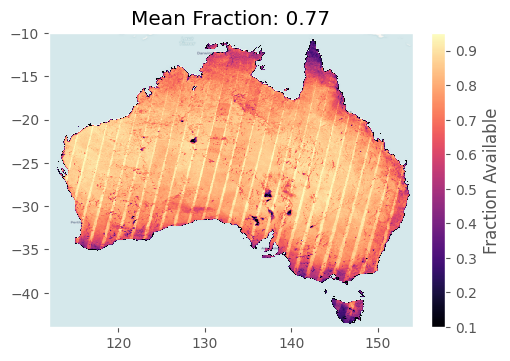

In [6]:
fraction_avail_ls = (~np.isnan(ls)).sum('time')/len(ls.time)
fraction_avail_merge = (~np.isnan(merge)).sum('time')/len(merge.time)

fig,ax=plt.subplots(1,1, figsize=(5,4),sharey=True, layout='constrained')

im = fraction_avail_ls.where(fraction_avail_ls>0).rename('').plot(vmin=0.1, vmax=0.95, ax=ax, cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cb = fig.colorbar(im, ax=ax, shrink=0.75, orientation='vertical', label='Fraction Available');
ax.set_title('Mean Fraction: '+str(round(fraction_avail_ls.where(fraction_avail_ls>0).mean().values.item(), 3)));

### Timeseries plots


#### per region

In [7]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


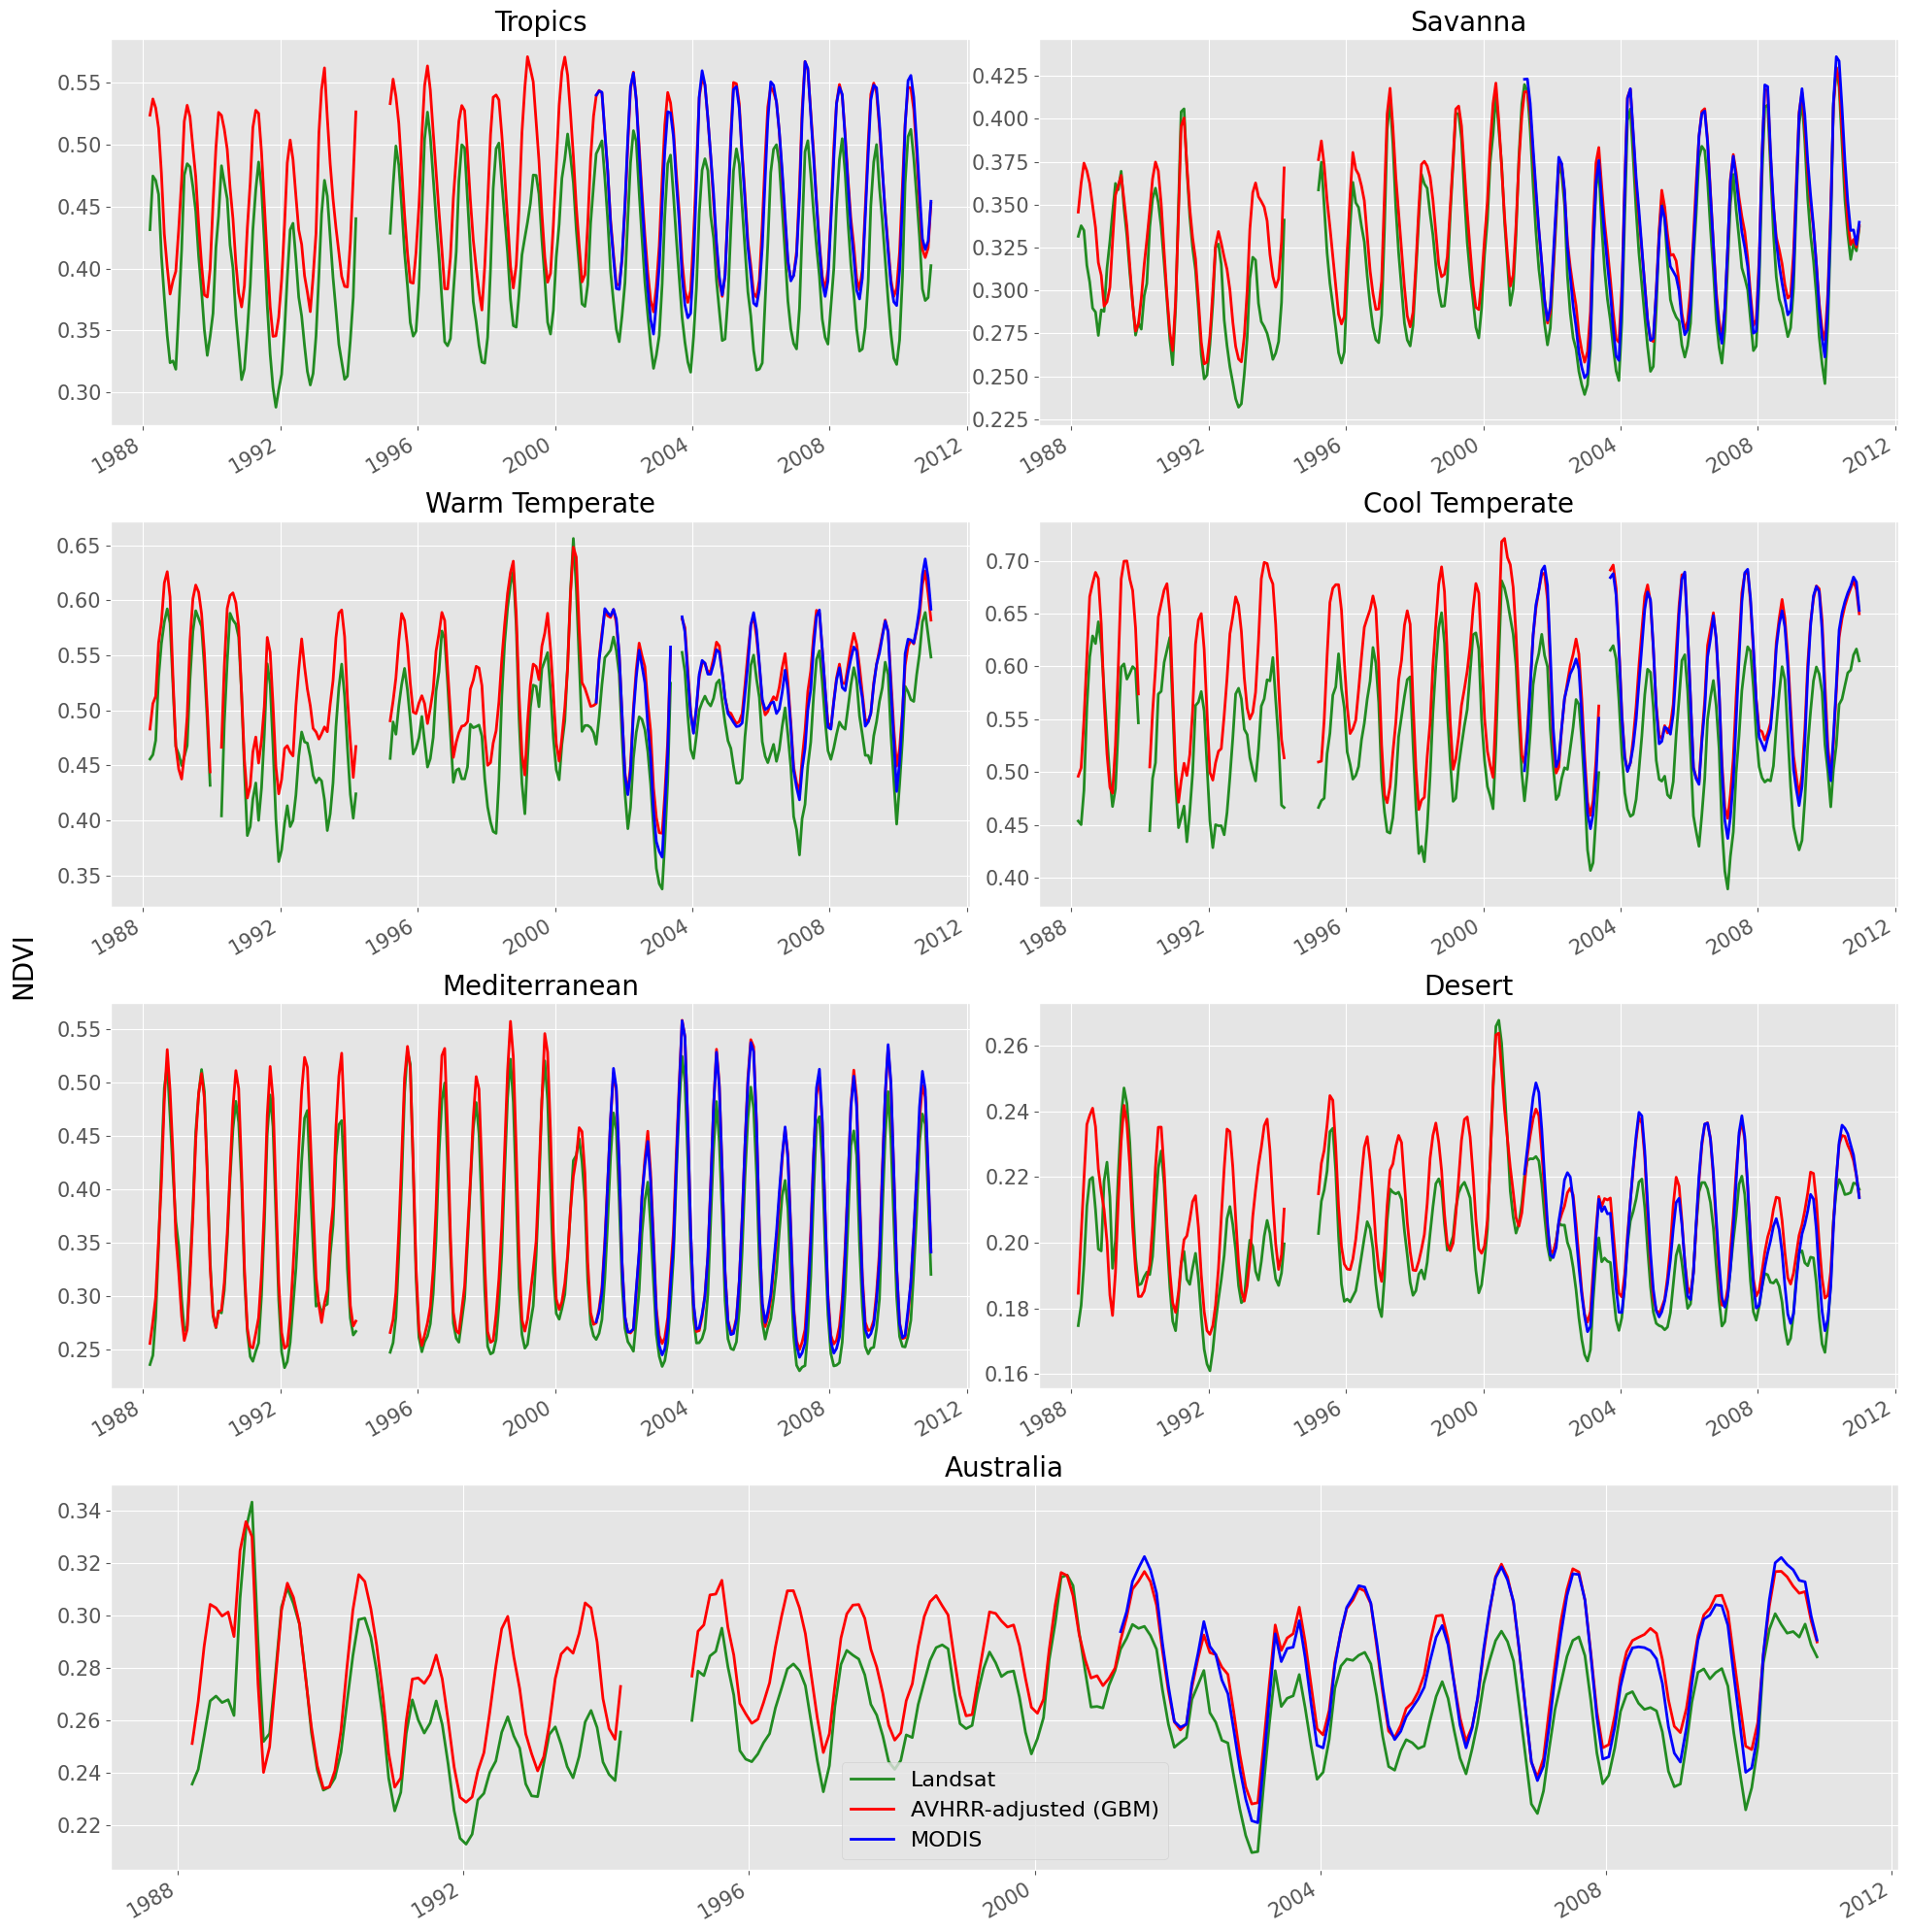

In [8]:
mosiac = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "G"],
]

fig, axes = plt.subplot_mosaic(mosiac, figsize=(20,20))

for ax, (index, row) in zip(axes, gdf.iterrows()):
    print(row['region_name'])
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ls, crs=crs)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ls_region = ls.where(mask)
    merge_region = merge.where(mask)
    modis_region = modis.where(mask)

    ls_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='Landsat', c ='forestgreen', linewidth=2)
    merge_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR-adjusted (GBM)', c='red', linewidth=2)
    modis_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='MODIS', c='blue', linewidth=2)
    
    axes[ax].set_ylabel('')
    axes[ax].set_xlabel('')
    # axes[ax].sharex(axes['E'])
    axes[ax].tick_params(axis='y', labelsize=15)
    axes[ax].tick_params(axis='x', labelsize=15)
    axes[ax].set_title(row['region_name'], fontsize=20)
    axes[ax].grid(True)

#the last Aus-wide plot
ls.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='Landsat', c ='forestgreen', linewidth=2)
merge.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-adjusted (GBM)', c='red', linewidth=2)
modis.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='MODIS', c='blue', linewidth=2)

axes['G'].set_title('Australia', fontsize=20)
axes['G'].legend(fontsize=16)
axes['G'].set_ylabel('')
axes['G'].set_xlabel('')
axes['G'].tick_params(axis='y', labelsize=15)
axes['G'].tick_params(axis='x', labelsize=15)
axes['G'].grid(True)

fig.supylabel(model_var, fontsize=20)    
plt.tight_layout(rect=(0.015,0,1,1))
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_landsat_timeseries_bioregion.png',
            bbox_inches='tight', dpi=300);

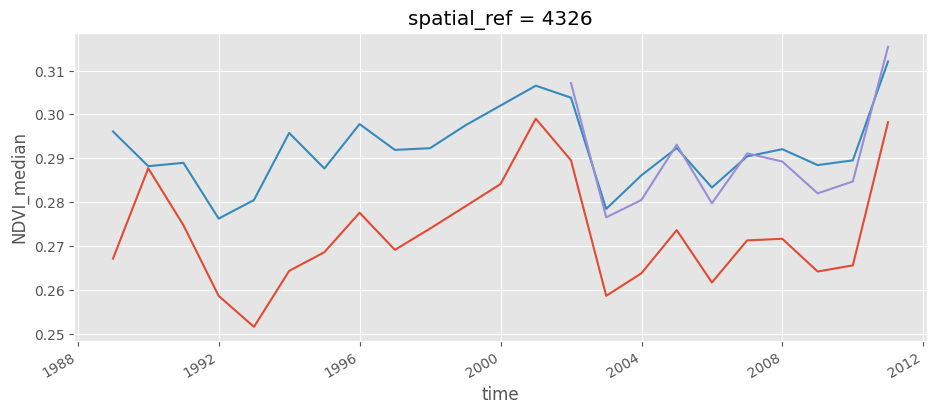

In [9]:
fig,ax = plt.subplots(1,1, figsize=(11,4), sharey=True)
ls.resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax)
merge.resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax)
modis.resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax)

In [10]:
# ls.sel(time='1993').plot.imshow(col='time', col_wrap=4, robust=True)

### Per-pixel error metrics

In [11]:
merge_mean = merge.mean('time')
low_ndvi_mask = xr.where(merge_mean<0.10,0, 1)

In [12]:
orig_corr = xr.corr(merge, ls, dim='time')
orig_corr = orig_corr.where(low_ndvi_mask)

orig_rmse = xs.rmse(merge,ls, dim='time', skipna=True)
orig_rmse = orig_rmse.where(low_ndvi_mask)

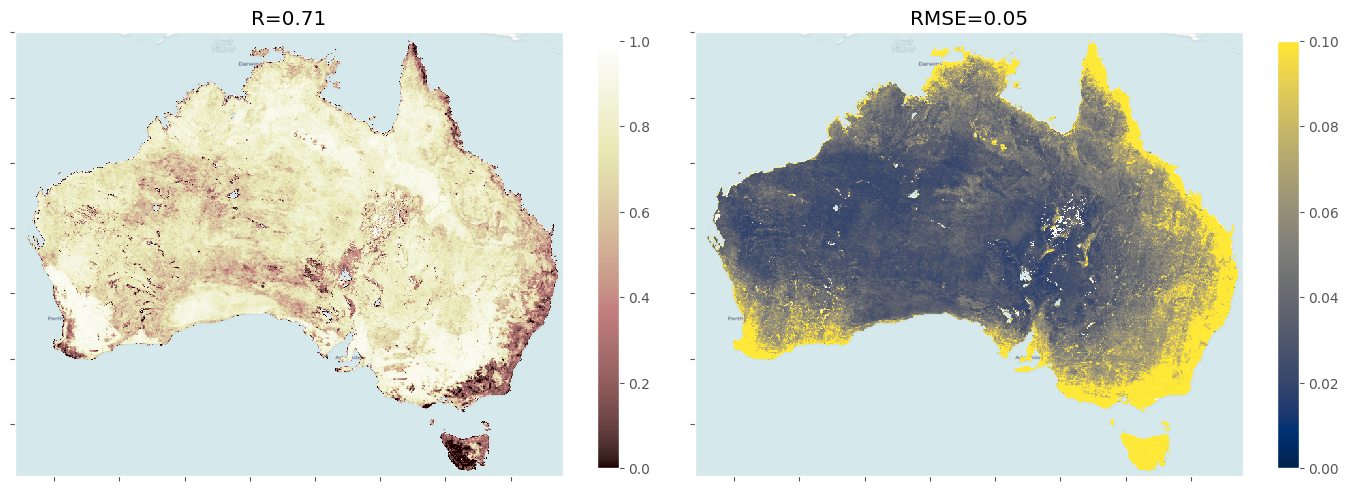

In [13]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
im = orig_corr.plot(vmin=0, vmax=1, cmap='pink', ax=ax[0], add_colorbar=False)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cb = fig.colorbar(im, ax=ax[0], shrink=0.75, orientation='vertical');
ax[0].set_title(f'R='"{:.2f}".format(orig_corr.mean().values))
ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

im = orig_rmse.plot(vmin=0, vmax=0.1, cmap='cividis', ax=ax[1], add_colorbar=False)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cb = fig.colorbar(im, ax=ax[1], shrink=0.75, orientation='vertical');
ax[1].set_title(f'RMSE='"{:.2f}".format(orig_rmse.mean().values))
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_xticklabels([]);

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_Landsat_perpixel.png',
            bbox_inches='tight', dpi=300);

## Residuals through time



In [14]:
#residuals after harmonization
residual = (ls - merge).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Landsat residuals')
residual_sd = (ls - merge).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Landsat residuals')

/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


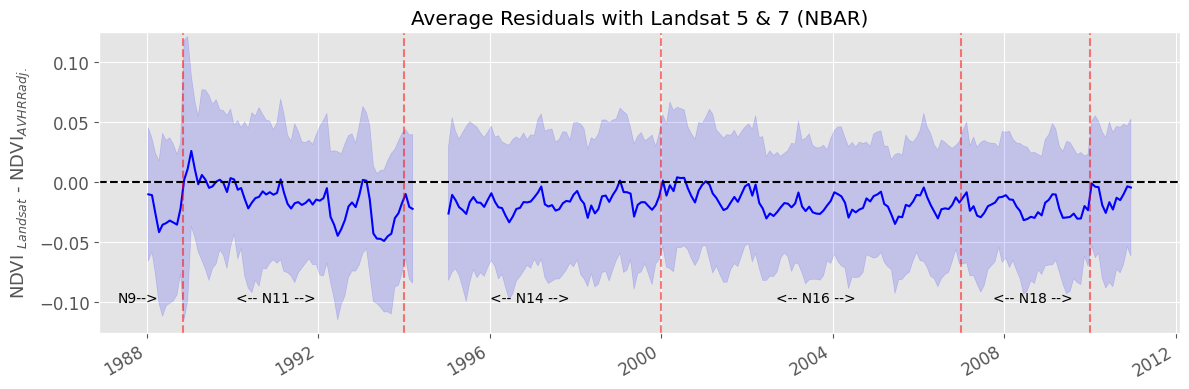

In [15]:
fig,ax = plt.subplots(1,1, figsize=(12,4), sharex=True)

residual.plot(ax=ax, legend=False, color='blue')
ax.fill_between(residual.index, (residual-residual_sd)['Landsat residuals'],
                (residual+residual_sd)['Landsat residuals'], alpha=0.15, color='blue')

ax.axhline(0.0, color='k', linestyle='--')
# ax.legend(loc='upper left')
ax.set_title('Average Residuals with Landsat 5 & 7 (NBAR)')
ax.set_ylim(-0.125, 0.125)
ax.set_ylabel(model_var+" $_{Landsat}$"+ " - "+model_var+"$_{AVHRR adj.}$", fontsize=13)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.axvline('1988-11', color='red', linestyle='--', alpha=0.5)
plt.text('1987-05',-0.1,'N9-->',rotation=0)

ax.axvline('1994', color='red', linestyle='--', alpha=0.5)
plt.text('1990-02',-0.1,'<-- N11 -->',rotation=0)

ax.axvline('2000', color='red', linestyle='--', alpha=0.5)
plt.text('1996',-0.1,'<-- N14 -->',rotation=0)

ax.axvline('2007', color='red', linestyle='--', alpha=0.5)
plt.text('2002-09',-0.1,'<-- N16 -->',rotation=0)

ax.axvline('2010', color='red', linestyle='--', alpha=0.5)
plt.text('2007-10',-0.1,'<-- N18 -->',rotation=0)

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_Landsat_residuals.png',
            bbox_inches='tight', dpi=300);

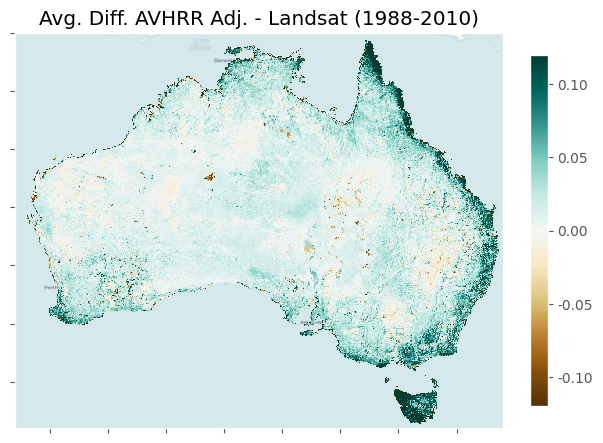

In [16]:
fig,ax = plt.subplots(1,1, figsize=(7,7))

im = (merge.mean('time') - ls.mean('time')).plot(robust=True, ax=ax, add_colorbar=False, cmap='BrBG', add_labels=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cbar = fig.colorbar(im, location='right', ax=ax, fraction=0.05, shrink=0.65)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Avg. Diff. AVHRR Adj. - Landsat (1988-2010)');